<a href="https://colab.research.google.com/github/victoruwazurike1/Hamoye_Internship_Notebooks/blob/main/hamoye_amazon_deforestation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 528524467855767254
xla_global_id: -1
]


In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [ ]:
files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# To test if whatI did is working.
! kaggle datasets list

ref                                                                       title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                                 2022 Ukraine Russia War                               1KB  2022-03-20 16:59:25           1958        150  1.0              
datasets/prasertk/healthy-lifestyle-cities-report-2021                    Healthy Lifestyle Cities Report 2021                  2KB  2022-03-03 00:26:02           2371         79  1.0              
datasets/prasertk/netflix-daily-top-10-in-us                              Netflix daily top 10                                 70KB  2022-03-12 13:22:19            996         27  1.0              
datasets/v

In [6]:
!kaggle datasets download nikitarom/planets-dataset -p /content/sample_data/ --unzip

 98% 1.47G/1.50G [00:06<00:00, 254MB/s]
100% 1.50G/1.50G [00:07<00:00, 228MB/s]


In [43]:
import os
import gc
# import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import cv2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from sklearn.model_selection import train_test_split
# import datahelper
# from data_helper import AmazonPreprocessor

In [8]:
train_labels = pd.read_csv('/content/sample_data/planet/planet/train_classes.csv')

In [9]:
print(train_labels.shape)
print(train_labels.head())

(40479, 2)
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


In [10]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_labels['tags'].values]))
labels_set = set(labels_list)
print("There are {} unique labels in this dataframe and they are: {}".format(len(labels_set), labels_set))

There are 17 unique labels in this dataframe and they are: {'water', 'agriculture', 'cloudy', 'selective_logging', 'bare_ground', 'clear', 'blow_down', 'road', 'cultivation', 'slash_burn', 'artisinal_mine', 'blooming', 'partly_cloudy', 'conventional_mine', 'haze', 'habitation', 'primary'}


Text(0, 0.5, 'Labels')

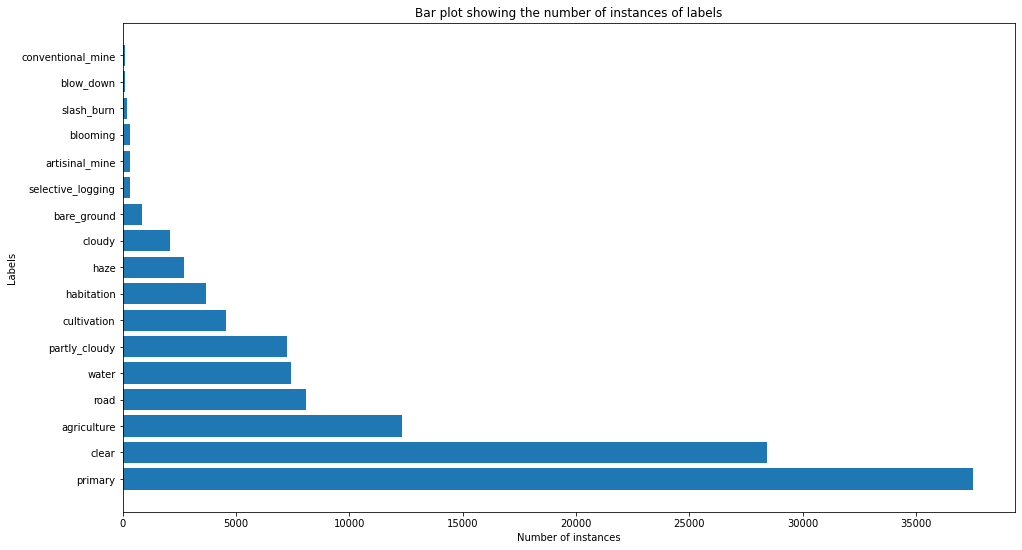

In [11]:
# Bar chart of label instances
labels = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 9))
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.barh(labels.index, labels)
plt.title('Bar plot showing the number of instances of labels')
plt.xlabel('Number of instances')
plt.ylabel('Labels')

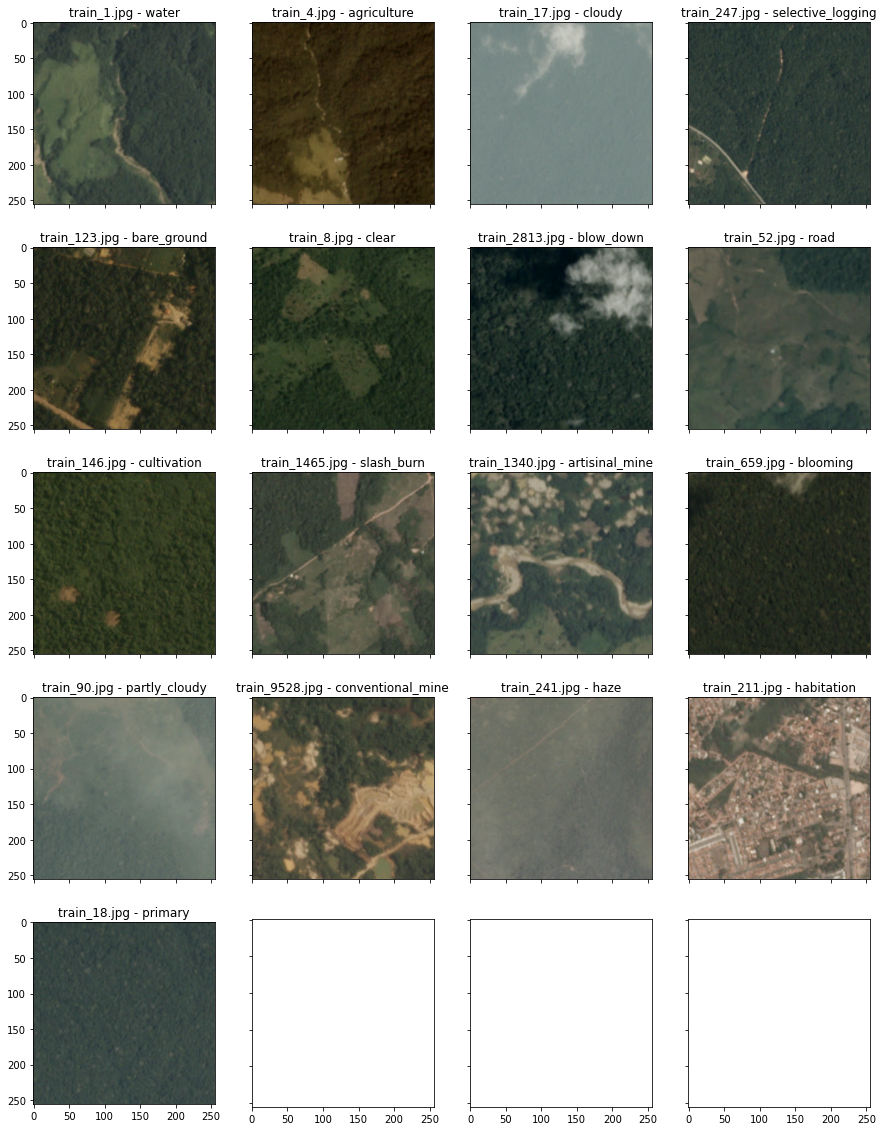

In [12]:
images_title = [train_labels[train_labels['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

img_folder = '/content/sample_data/planet/planet/train-jpg/'
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(img_folder + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

In [13]:
df_train,df_valid = train_test_split(train_labels,test_size= 0.3)

In [14]:
df_train

,image_name,tags
11851,train_11851,partly_cloudy primary
21745,train_21745,haze primary road
32211,train_32211,partly_cloudy primary road water
28762,train_28762,cloudy
17808,train_17808,agriculture clear cultivation primary
...,...,...
8815,train_8815,clear primary water
2469,train_2469,agriculture cultivation partly_cloudy primary
37512,train_37512,clear primary
19457,train_19457,clear primary


In [15]:
df_valid

,image_name,tags
12969,train_12969,clear primary road water
34913,train_34913,clear primary water
11707,train_11707,agriculture partly_cloudy primary road
22362,train_22362,agriculture partly_cloudy primary road
33027,train_33027,clear primary
...,...,...
35050,train_35050,bare_ground clear road
40052,train_40052,agriculture clear habitation primary road
7773,train_7773,clear primary
7681,train_7681,agriculture partly_cloudy primary


In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels_s = list(set(flatten([l.split(' ') for l in train_labels['tags'].values])))

label_map = {l: i for i, l in enumerate(labels_s)}
inv_label_map = {i: l for l, i in label_map.items()}

In [17]:
input_size = 128
input_channels = 3

epochs = 50
batch_size = 128

In [18]:
def transformations(src, choice):
    if choice == 0:
        # Rotate 90
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
    if choice == 1:
        # Rotate 90 and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        src = cv2.flip(src, flipCode=1)
    if choice == 2:
        # Rotate 180
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
    if choice == 3:
        # Rotate 180 and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
        src = cv2.flip(src, flipCode=1)
    if choice == 4:
        # Rotate 90 counter-clockwise
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
    if choice == 5:
        # Rotate 90 counter-clockwise and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        src = cv2.flip(src, flipCode=1)
    return src

In [19]:
# Let us define a function for training_data_generator
def train_generator():
    while True:
        for start in range(0, len(df_train), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df_train))
            df_train_batch = df_train[start:end]
            for f, tags in df_train_batch.values:
                img = cv2.imread('/content/sample_data/planet/planet/train-jpg/{}.jpg'.format(f))
                img = cv2.resize(img, (input_size, input_size))
                img = transformations(img, np.random.randint(6))
                img = img/255
                targets = np.zeros(17)
                for t in tags.split(' '):
                    targets[label_map[t]] = 1
                x_batch.append(img)
                y_batch.append(targets)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

In [65]:
# df_train_batch = df_train[1:100]
# f, tags = df_train_batch.values
# print(f)
# print(tags)
img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/train_0.jpg')
print(img)

None


In [21]:
# Let us define a function for validation_data_generator
def valid_generator():
    while True:
        for start in range(0, len(df_valid), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df_valid))
            df_valid_batch = df_valid[start:end]
            for f, tags in df_valid_batch.values:
                img = cv2.imread('/content/sample_data/planet/planet/train-jpg/{}.jpg'.format(f))
                img = cv2.resize(img, (input_size, input_size))
                img = img/255
                targets = np.zeros(17)
                for t in tags.split(' '):
                    targets[label_map[t]] = 1
                x_batch.append(img)
                y_batch.append(targets)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch
            print(img.shape)

In [58]:
valid_generator()

<generator object valid_generator at 0x7f94c34d84d0>

In [20]:
train_gen = train_generator()
train_x,train_y = next(train_gen)
print(train_x.shape)
print(train_y.shape)

(128, 128, 128, 3)
(128, 17)


In [22]:
valid_gen = valid_generator()
valid_x,valid_y = next(valid_gen)
print(valid_x.shape)
print(valid_y.shape)

(128, 128, 128, 3)
(128, 17)


In [23]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [24]:
# define input shape and output shape
in_shape=(128, 128, 3)
out_shape=17

In [25]:
# Define a function to display the learning curve 
def display_curve(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'],color='blue', label='train')
    plt.plot(history.history['val_loss'],color='orange',label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'],color='blue',label='train')
    plt.plot(history.history['val_fbeta'],color='orange',label='test')
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename+'_plot.png')
    plt.show()
    plt.close()


In [37]:
# Defining a VGG19 model as that's what I will be using for this training
class VGG19(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu', input_shape= input_shape))
        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(out_shape, activation= 'sigmoid'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.003),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


In [38]:
model = VGG19((128, 128, 3))

In [39]:
opt = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy',
                  # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer=opt,
                  metrics=[fbeta])
model.summary()

Model: "vgg19_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_cgg.h5', 
    monitor='val_fbeta', mode='max', 
    save_best_only=True, save_weights_only=True, 
    verbose=1
)
early =tf.keras.callbacks.EarlyStopping(monitor="val_fbeta", 
                      mode="max", 
                      patience=6)

In [44]:
history=model.fit_generator(generator=train_generator(),
                                  
                            steps_per_epoch=(len(df_train) // batch_size) + 1,
                            epochs=20,
                            verbose=1,
                            callbacks=[ checkpoint,early],
                            validation_data=valid_generator(),
                            validation_steps=(len(df_valid) // batch_size) + 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


TypeError: ignored